# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [1]:
# # Be sure to install the latest version of RLlib and sundry requirements
# ! pip install -U ray[rllib]
# ! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow-gpu==1.14.0

In [2]:
# view dependencies
! pip list | grep tensorflow

tensorflow             1.14.0             
tensorflow-estimator   1.14.0             
tensorflow-gpu         1.14.0             


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ten

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [4]:
# Start ray locally (there are lots of configurations)
# to remote access ray dashboard, use ssh -L 8888:localhost:8265 local_host@xxx.xxx.xxx.xx
# on local: http://localhost:8888
ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2020-03-11 16:22:03,757	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-11 16:22:03,758	INFO resource_spec.py:212 -- Starting Ray with 7.76 GiB memory available for workers and up to 3.9 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-11 16:22:04,125	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:55026',
 'object_store_address': '/tmp/ray/session_2020-03-11_16-22-03_752911_12897/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-11_16-22-03_752911_12897/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-11_16-22-03_752911_12897'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [5]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2, 'num_envs_per_worker': 1, 'sample_batch_size': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_preprocessor': None, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_level': 'WARN', 'callbacks': {'on_episode_start': None, 'on_episode_step': None, 'on_episode_end': Non

In [6]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'Pong-ram-v0')


2020-03-10 17:31:16,624	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-10 17:31:16,627	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-03-10_17-31-24
done: false
episode_len_mean: 1248.0
episode_reward_max: -20.0
episode_reward_mean: -20.333333333333332
episode_reward_min: -21.0
episodes_this_iter: 3
episodes_total: 3
experiment_id: 6507435c45c14468bd2b319ebfaaf302
hostname: qian-XPS-8920
info:
  grad_time_ms: 1305.772
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 1.7822446823120117
      entropy_coeff: 0.0
      kl: 0.009407696314156055
      policy_loss: -0.0038971842732280493
      total_loss: 0.4376855790615082
      vf_explained_var: 0.0065327961929142475
      vf_loss: 0.43970122933387756
  load_time_ms: 52.684
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 4162.778
  update_time_ms: 357.342
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 32.37777777777777
  gpu_util_percent0: 0.030000000000000002
  ram_util_p

In [7]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [8]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[-4.0115070e-02 -2.7820475e+38 -3.5773429e-01  2.6301286e+37]


In [17]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [18]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-23 17:48:03,561	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [19]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-23_17-48-20
done: false
episode_len_mean: 22.885057471264368
episode_reward_max: 83.0
episode_reward_mean: 22.885057471264368
episode_reward_min: 8.0
episodes_this_iter: 174
episodes_total: 174
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 1035.934
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6627660393714905
      entropy_coeff: 0.0
      kl: 0.030408170074224472
      policy_loss: -0.04281337186694145
      total_loss: 190.5047607421875
      vf_explained_var: 0.018993224948644638
      vf_loss: 190.54150390625
  load_time_ms: 37.091
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 821.954
  update_time_ms: 308.361
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 10.908333333333333
  ram_util_percent: 72.46666666666668
pid: 30552
p

custom_metrics: {}
date: 2020-02-23_17-48-29
done: false
episode_len_mean: 162.28
episode_reward_max: 200.0
episode_reward_mean: 162.28
episode_reward_min: 15.0
episodes_this_iter: 22
episodes_total: 413
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 852.671
  learner:
    default_policy:
      cur_kl_coeff: 0.07500000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.5493625402450562
      entropy_coeff: 0.0
      kl: 0.0024292394518852234
      policy_loss: -0.004398831631988287
      total_loss: 595.1405029296875
      vf_explained_var: 0.3493116796016693
      vf_loss: 595.1447143554688
  load_time_ms: 6.063
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 766.55
  update_time_ms: 45.766
iterations_since_restore: 7
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.7
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
policy

custom_metrics: {}
date: 2020-02-23_17-48-39
done: false
episode_len_mean: 187.5
episode_reward_max: 200.0
episode_reward_mean: 187.5
episode_reward_min: 22.0
episodes_this_iter: 23
episodes_total: 542
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 823.776
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5304279923439026
      entropy_coeff: 0.0
      kl: 0.007987464778125286
      policy_loss: -0.0023089575115591288
      total_loss: 292.8392028808594
      vf_explained_var: 0.5363507270812988
      vf_loss: 292.8414611816406
  load_time_ms: 0.891
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 742.016
  update_time_ms: 1.954
iterations_since_restore: 13
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 43.65
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
polic

custom_metrics: {}
date: 2020-02-23_17-48-49
done: false
episode_len_mean: 198.06
episode_reward_max: 200.0
episode_reward_mean: 198.06
episode_reward_min: 60.0
episodes_this_iter: 20
episodes_total: 662
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 866.448
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5659090280532837
      entropy_coeff: 0.0
      kl: 0.005861836951225996
      policy_loss: -0.0025119411293417215
      total_loss: 261.8939208984375
      vf_explained_var: 0.5556763410568237
      vf_loss: 261.8963623046875
  load_time_ms: 0.931
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 787.942
  update_time_ms: 2.274
iterations_since_restore: 19
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 54.099999999999994
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward

In [20]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20


In [21]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-23 17:50:02,001	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-23 17:50:02,060	WARNING trainable.py:210 -- Getting current IP.
2020-02-23 17:50:02,061	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20
2020-02-23 17:50:02,061	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 80000, '_time_total': 33.20142102241516, '_episodes_total': 683}


### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [25]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

     |████████████████████████████████| 13.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.4 MB/s eta 0:00:0101


In [40]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0")

In [41]:
df = analysis.dataframe() # last trial from checkpoint

In [43]:
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0']

<IPython.core.display.Javascript object>


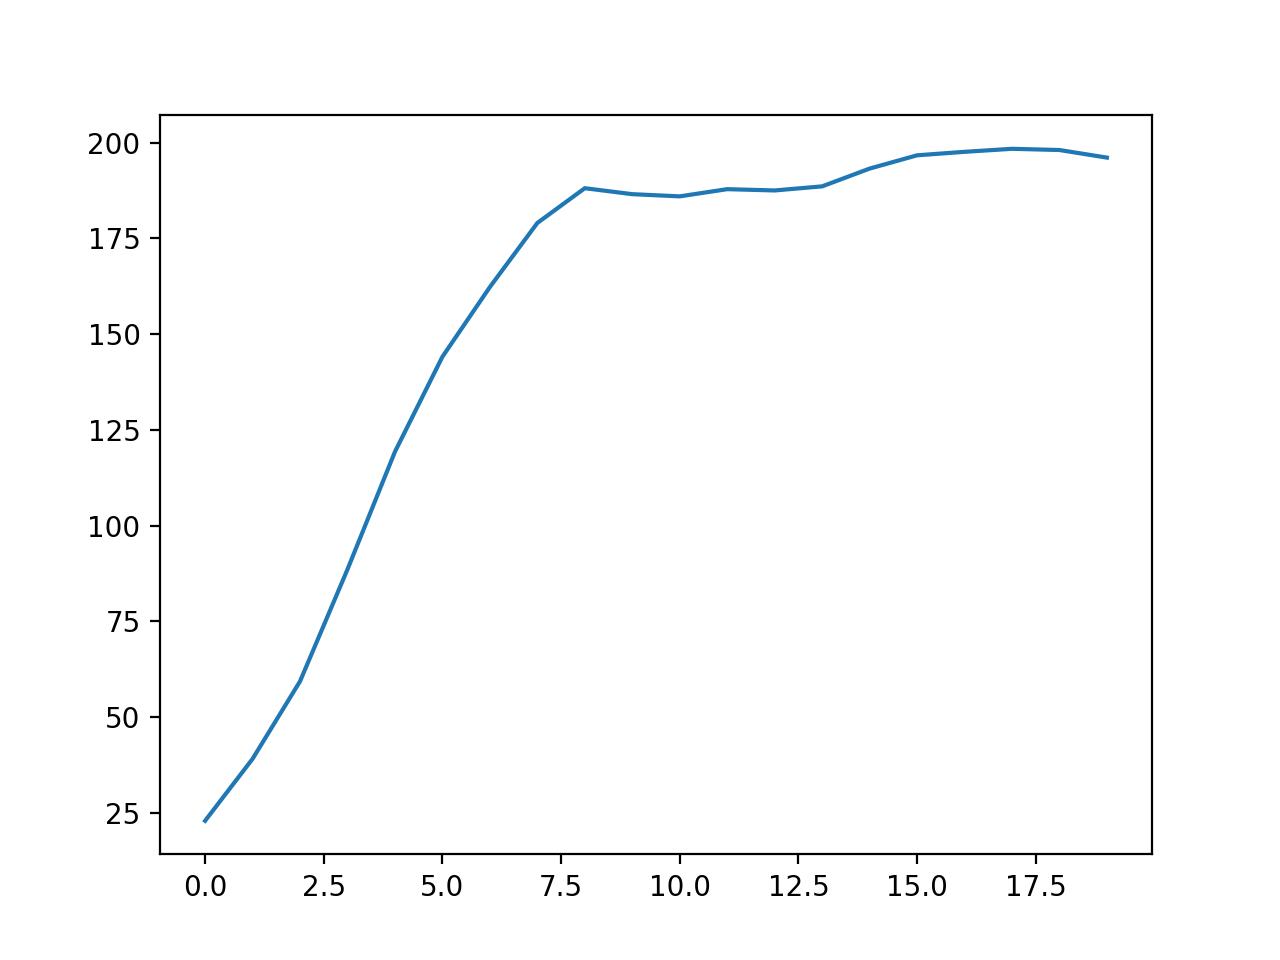

In [44]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [45]:
! pip install tensorboard

In [46]:
! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [1]:
# ! pip install pyyaml # install package to read yamls, import with yaml

In [5]:
import yaml
import urllib

In [6]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/rl-experiments/master/pong-speedrun/pong-impala-fast.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# This can reach 18-19 reward in ~3 minutes on p3.16xl head w/m4.16xl workers\n#   128 workers -> 3 minutes (best case)\n#    64 workers -> 4 minutes\n#    32 workers -> 7 minutes\n# See also: pong-impala.yaml, pong-impala-vectorized.yaml\npong-impala-fast:\n    env: PongNoFrameskip-v4\n    run: IMPALA\n    config:\n        sample_batch_size: 50\n        train_batch_size: 1000\n        num_workers: 128\n        num_envs_per_worker: 5\n        broadcast_interval: 5\n        max_sample_requests_in_flight_per_worker: 1\n        num_data_loader_buffers: 4\n        num_gpus: 2\n        model:\n          dim: 42\n'


In [7]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-impala-fast': {'env': 'PongNoFrameskip-v4', 'run': 'IMPALA', 'config': {'sample_batch_size': 50, 'train_batch_size': 1000, 'num_workers': 128, 'num_envs_per_worker': 5, 'broadcast_interval': 5, 'max_sample_requests_in_flight_per_worker': 1, 'num_data_loader_buffers': 4, 'num_gpus': 2, 'model': {'dim': 42}}}}


In [8]:
# tune_config_example["pong-ppo"]["env"] = "Pong-ram-v0"
tune_config_example["pong-impala-fast"]["config"]["num_workers"] = 7
tune_config_example["pong-impala-fast"]["config"]["num_gpus"]=1
# tune_config_example["pong-ppo"]["config"]["sample_batch_size"]=80
# tune_config_example["pong-ppo"]["config"]["num_sgd_iter"]=40
print(tune_config_example)

{'pong-impala-fast': {'env': 'PongNoFrameskip-v4', 'run': 'IMPALA', 'config': {'sample_batch_size': 50, 'train_batch_size': 1000, 'num_workers': 7, 'num_envs_per_worker': 5, 'broadcast_interval': 5, 'max_sample_requests_in_flight_per_worker': 1, 'num_data_loader_buffers': 4, 'num_gpus': 1, 'model': {'dim': 42}}}}


In [9]:
ray.tune.run_experiments(tune_config_example)

Trial name,status,loc
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-22-44
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 28
  episodes_total: 28
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 2.0085663479121017e-14
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -0.0
      var_gnorm: 9.91195297241211
      vf_explained_var: -0.0058441162109375
      vf_loss: 49.90560531616211
    learner_queue:
      size_count: 28
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_weight_syncs: 114
    sample_throughput: 2343.206
    

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,10.5084,28000,1


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-22-55
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 63
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 6.190255135152256e-06
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -0.0
      var_gnorm: 9.982680320739746
      vf_explained_var: 0.00839298963546753
      vf_loss: 72.2553482055664
    learner_queue:
      size_count: 62
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 62000
    num_steps_trained: 61000
    num_weight_syncs: 250
    sample_throughput: 3249.399
    t

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,20.9591,62000,2


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-05
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 98
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 0.007373851723968983
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 0.00021057658887002617
      var_gnorm: 10.001086235046387
      vf_explained_var: 0.021030008792877197
      vf_loss: 173.59410095214844
    learner_queue:
      size_count: 96
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 96000
    num_steps_trained: 95000
    num_weight_syncs: 386
    sample_throughput: 3240.49

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,31.4391,96000,3


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-15
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 50
  episodes_total: 148
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 6.283613334043541e-16
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.056659698486328
      vf_explained_var: 0.017927825450897217
      vf_loss: 62.24956512451172
    learner_queue:
      size_count: 130
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 130000
    num_steps_trained: 129000
    num_weight_syncs: 521
    sample_throughput: 3267.986
    timing_b

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,41.8297,130000,4


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-26
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 55
  episodes_total: 203
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 7.110878641469753e-07
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.091085433959961
      vf_explained_var: 0.029599905014038086
      vf_loss: 138.8087158203125
    learner_queue:
      size_count: 164
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 164000
    num_steps_trained: 163000
    num_weight_syncs: 657
    sample_throughput: 3250.414
    timing_b

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,52.2776,164000,5


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-36
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 238
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 6.406325908788027e-17
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.167047500610352
      vf_explained_var: 0.15899813175201416
      vf_loss: 61.51532745361328
    learner_queue:
      size_count: 198
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 198000
    num_steps_trained: 197000
    num_weight_syncs: 793
    sample_throughput: 3258.641
    timing_br

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,62.699,198000,6


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-47
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 273
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 6.1076838031581815e-12
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.224838256835938
      vf_explained_var: 0.23049664497375488
      vf_loss: 48.89368438720703
    learner_queue:
      size_count: 232
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 232000
    num_steps_trained: 231000
    num_weight_syncs: 928
    sample_throughput: 3267.34

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,73.0923,232000,7


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-23-57
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 65
  episodes_total: 338
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1.4555118221792895e-09
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.296533584594727
      vf_explained_var: 0.3545066714286804
      vf_loss: 47.459495544433594
    learner_queue:
      size_count: 265
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 265000
    num_steps_trained: 265000
    num_weight_syncs: 1063
    sample_throughput: 3158.6

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,83.5273,265000,8


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-24-08
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 40
  episodes_total: 378
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 6.577712338184938e-05
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.38475227355957
      vf_explained_var: 0.3041698932647705
      vf_loss: 67.32534790039062
    learner_queue:
      size_count: 299
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 299000
    num_steps_trained: 299000
    num_weight_syncs: 1198
    sample_throughput: 3268.766


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,93.9156,299000,9


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-24-18
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 413
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 9.33436581362912e-07
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.0
      var_gnorm: 10.503600120544434
      vf_explained_var: 0.6846728324890137
      vf_loss: 15.094996452331543
    learner_queue:
      size_count: 333
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 333000
    num_steps_trained: 333000
    num_weight_syncs: 1334
    sample_throughput: 3267.677
    timing_br

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,104.308,333000,10


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-24-29
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 46
  episodes_total: 459
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 0.0006908189970999956
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -3.471209453209667e-08
      var_gnorm: 10.611527442932129
      vf_explained_var: 0.8291065692901611
      vf_loss: 9.572349548339844
    learner_queue:
      size_count: 367
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 367000
    num_steps_trained: 366000
    num_weight_syncs: 1471
    sample_throughput: 3232

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,114.813,367000,11


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-24-39
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 54
  episodes_total: 513
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 4.4295148849487305
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.11964450776576996
      var_gnorm: 10.687281608581543
      vf_explained_var: 0.769416332244873
      vf_loss: 36.68797302246094
    learner_queue:
      size_count: 401
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 401000
    num_steps_trained: 401000
    num_weight_syncs: 1606
    sample_throughput: 3256.987
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,125.24,401000,12


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-24-49
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 40
  episodes_total: 553
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 649.2923583984375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -3.9020564556121826
      var_gnorm: 10.77084732055664
      vf_explained_var: 0.9010138511657715
      vf_loss: 2.4020020961761475
    learner_queue:
      size_count: 435
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 435000
    num_steps_trained: 434000
    num_weight_syncs: 1742
    sample_throughpu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,135.672,435000,13


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-00
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 588
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 406.1515808105469
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -2.779203414916992
      var_gnorm: 10.885876655578613
      vf_explained_var: 0.9948538541793823
      vf_loss: 0.27158284187316895
    learner_queue:
      size_count: 469
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 469000
    num_steps_trained: 468000
    num_weight_syncs: 1877
    sample_throughp

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,146.071,469000,14


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-10
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 55
  episodes_total: 643
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 684.3929443359375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 74.81912994384766
      var_gnorm: 10.955300331115723
      vf_explained_var: 0.3704206347465515
      vf_loss: 50.47029113769531
    learner_queue:
      size_count: 502
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 502000
    num_steps_trained: 502000
    num_weight_syncs: 2011
    sample_throughput: 3171.603
    

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,156.463,502000,15


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-21
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 50
  episodes_total: 693
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1192.4285888671875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 204.80088806152344
      var_gnorm: 11.072354316711426
      vf_explained_var: 0.1699962615966797
      vf_loss: 91.99214172363281
    learner_queue:
      size_count: 536
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 536000
    num_steps_trained: 535000
    num_weight_syncs: 2146
    sample_throughput: 3259.72
   

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-21,166.881,536000,16


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-31
  done: false
  episode_len_mean: 3133.18
  episode_reward_max: -20.0
  episode_reward_mean: -20.91
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 728
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1243.5333251953125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -0.7852026224136353
      var_gnorm: 11.126350402832031
      vf_explained_var: 0.8954365253448486
      vf_loss: 4.030021667480469
    learner_queue:
      size_count: 570
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 570000
    num_steps_trained: 569000
    num_weight_syncs: 2282
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.91,177.297,570000,17


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-42
  done: false
  episode_len_mean: 3220.65
  episode_reward_max: -20.0
  episode_reward_mean: -20.81
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 763
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1197.749267578125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -17.25745964050293
      var_gnorm: 11.269607543945312
      vf_explained_var: 0.6140624284744263
      vf_loss: 5.678046226501465
    learner_queue:
      size_count: 604
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 604000
    num_steps_trained: 604000
    num_weight_syncs: 2418
    sample_throughput: 3239.761
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.81,187.779,604000,18


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-25-52
  done: false
  episode_len_mean: 3386.15
  episode_reward_max: -19.0
  episode_reward_mean: -20.58
  episode_reward_min: -21.0
  episodes_this_iter: 36
  episodes_total: 799
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1292.041259765625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -43.93090057373047
      var_gnorm: 11.610307693481445
      vf_explained_var: 0.5274286270141602
      vf_loss: 13.120972633361816
    learner_queue:
      size_count: 638
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 638000
    num_steps_trained: 638000
    num_weight_syncs: 2553
    sample_throughput: 3258.093


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.58,198.201,638000,19


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-02
  done: false
  episode_len_mean: 3445.16
  episode_reward_max: -19.0
  episode_reward_mean: -20.54
  episode_reward_min: -21.0
  episodes_this_iter: 45
  episodes_total: 844
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1302.8270263671875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 4.7856550216674805
      var_gnorm: 12.014742851257324
      vf_explained_var: 0.7774420380592346
      vf_loss: 11.71455192565918
    learner_queue:
      size_count: 672
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 672000
    num_steps_trained: 671000
    num_weight_syncs: 2688
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.54,208.584,672000,20


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-13
  done: false
  episode_len_mean: 3416.74
  episode_reward_max: -19.0
  episode_reward_mean: -20.66
  episode_reward_min: -21.0
  episodes_this_iter: 42
  episodes_total: 886
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1438.8963623046875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 60.31205749511719
      var_gnorm: 12.262328147888184
      vf_explained_var: 0.6993663311004639
      vf_loss: 20.83046531677246
    learner_queue:
      size_count: 705
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 705000
    num_steps_trained: 705000
    num_weight_syncs: 2823
    sample_throughput: 3168.219
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.66,218.987,705000,21


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-23
  done: false
  episode_len_mean: 3421.72
  episode_reward_max: -17.0
  episode_reward_mean: -20.67
  episode_reward_min: -21.0
  episodes_this_iter: 39
  episodes_total: 925
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1662.3336181640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -18.767887115478516
      var_gnorm: 12.48880386352539
      vf_explained_var: 0.6945608854293823
      vf_loss: 19.4770565032959
    learner_queue:
      size_count: 740
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 740000
    num_steps_trained: 739000
    num_weight_syncs: 2960
    sample_throughput: 3333.163
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.67,229.475,740000,22


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-34
  done: false
  episode_len_mean: 3504.67
  episode_reward_max: -17.0
  episode_reward_mean: -20.54
  episode_reward_min: -21.0
  episodes_this_iter: 40
  episodes_total: 965
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1588.15234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 133.72320556640625
      var_gnorm: 12.781712532043457
      vf_explained_var: 0.6437276005744934
      vf_loss: 32.654998779296875
    learner_queue:
      size_count: 774
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 774000
    num_steps_trained: 773000
    num_weight_syncs: 3097
    sample_throughput: 3230.61
    t

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.54,239.986,774000,23


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-44
  done: false
  episode_len_mean: 3535.29
  episode_reward_max: -17.0
  episode_reward_mean: -20.45
  episode_reward_min: -21.0
  episodes_this_iter: 40
  episodes_total: 1005
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1599.383544921875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 31.953630447387695
      var_gnorm: 13.004910469055176
      vf_explained_var: 0.8404693603515625
      vf_loss: 13.276896476745605
    learner_queue:
      size_count: 808
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 808000
    num_steps_trained: 807000
    num_weight_syncs: 3234
    sample_throughput: 3245.763

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.45,250.448,808000,24


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-26-55
  done: false
  episode_len_mean: 3434.5
  episode_reward_max: -18.0
  episode_reward_mean: -20.58
  episode_reward_min: -21.0
  episodes_this_iter: 39
  episodes_total: 1044
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1681.9005126953125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 14.644647598266602
      var_gnorm: 13.164284706115723
      vf_explained_var: 0.7714036703109741
      vf_loss: 18.333057403564453
    learner_queue:
      size_count: 842
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 842000
    num_steps_trained: 842000
    num_weight_syncs: 3370
    sample_throughput: 3259.084

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.58,260.868,842000,25


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-05
  done: false
  episode_len_mean: 3403.51
  episode_reward_max: -18.0
  episode_reward_mean: -20.61
  episode_reward_min: -21.0
  episodes_this_iter: 36
  episodes_total: 1080
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1662.663818359375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -42.13800048828125
      var_gnorm: 13.34787654876709
      vf_explained_var: 0.7157775163650513
      vf_loss: 21.4232177734375
    learner_queue:
      size_count: 876
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 876000
    num_steps_trained: 875000
    num_weight_syncs: 3505
    sample_throughput: 3276.571
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.61,271.231,876000,26


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-16
  done: false
  episode_len_mean: 3496.1
  episode_reward_max: -18.0
  episode_reward_mean: -20.53
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 1115
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1719.791748046875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -36.872806549072266
      var_gnorm: 13.492778778076172
      vf_explained_var: 0.47007036209106445
      vf_loss: 25.893020629882812
    learner_queue:
      size_count: 910
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 910000
    num_steps_trained: 909000
    num_weight_syncs: 3641
    sample_throughput: 3259.45

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.53,281.649,910000,27


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-26
  done: false
  episode_len_mean: 3647.77
  episode_reward_max: -18.0
  episode_reward_mean: -20.33
  episode_reward_min: -21.0
  episodes_this_iter: 37
  episodes_total: 1152
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1634.4840087890625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -8.770087242126465
      var_gnorm: 13.628939628601074
      vf_explained_var: 0.6429784893989563
      vf_loss: 15.862067222595215
    learner_queue:
      size_count: 944
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 944000
    num_steps_trained: 943000
    num_weight_syncs: 3777
    sample_throughput: 3246.72

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.33,292.109,944000,28


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-36
  done: false
  episode_len_mean: 3642.36
  episode_reward_max: -18.0
  episode_reward_mean: -20.32
  episode_reward_min: -21.0
  episodes_this_iter: 40
  episodes_total: 1192
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1667.537353515625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 207.74041748046875
      var_gnorm: 13.818253517150879
      vf_explained_var: 0.7659886479377747
      vf_loss: 46.778282165527344
    learner_queue:
      size_count: 978
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 978000
    num_steps_trained: 977000
    num_weight_syncs: 3913
    sample_throughput: 3244.988

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.32,302.574,978000,29


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-47
  done: false
  episode_len_mean: 3624.8
  episode_reward_max: -18.0
  episode_reward_mean: -20.21
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 1227
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1698.872802734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -82.8425064086914
      var_gnorm: 13.959712982177734
      vf_explained_var: 0.573201060295105
      vf_loss: 25.131118774414062
    learner_queue:
      size_count: 1012
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1012000
    num_steps_trained: 1011000
    num_weight_syncs: 4049
    sample_throughput: 3257.459

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.21,312.999,1012000,30


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-27-57
  done: false
  episode_len_mean: 3692.54
  episode_reward_max: -18.0
  episode_reward_mean: -20.12
  episode_reward_min: -21.0
  episodes_this_iter: 39
  episodes_total: 1266
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1618.65625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -4.920584678649902
      var_gnorm: 14.158555030822754
      vf_explained_var: 0.8303945064544678
      vf_loss: 10.154319763183594
    learner_queue:
      size_count: 1046
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1046000
    num_steps_trained: 1045000
    num_weight_syncs: 4184
    sample_throughput

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.12,323.384,1046000,31


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-28-08
  done: false
  episode_len_mean: 3742.12
  episode_reward_max: -18.0
  episode_reward_mean: -19.99
  episode_reward_min: -21.0
  episodes_this_iter: 42
  episodes_total: 1308
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1692.2939453125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 8.095510482788086
      var_gnorm: 14.317482948303223
      vf_explained_var: 0.7198552489280701
      vf_loss: 24.241432189941406
    learner_queue:
      size_count: 1080
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1080000
    num_steps_trained: 1080000
    num_weight_syncs: 4321
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.99,333.912,1080000,32


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-28-18
  done: false
  episode_len_mean: 3687.91
  episode_reward_max: -18.0
  episode_reward_mean: -20.12
  episode_reward_min: -21.0
  episodes_this_iter: 37
  episodes_total: 1345
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1671.63330078125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -39.26728057861328
      var_gnorm: 14.474471092224121
      vf_explained_var: 0.8476907014846802
      vf_loss: 14.572874069213867
    learner_queue:
      size_count: 1114
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1114000
    num_steps_trained: 1113000
    num_weight_syncs: 4457
    sample_thro

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.12,344.397,1114000,33


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-28-29
  done: false
  episode_len_mean: 3616.95
  episode_reward_max: -18.0
  episode_reward_mean: -20.29
  episode_reward_min: -21.0
  episodes_this_iter: 30
  episodes_total: 1375
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1660.5638427734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -63.22930908203125
      var_gnorm: 14.593052864074707
      vf_explained_var: 0.8867931365966797
      vf_loss: 11.762579917907715
    learner_queue:
      size_count: 1148
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1148000
    num_steps_trained: 1147000
    num_weight_syncs: 4592
    sample_throughput: 3267

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.29,354.79,1148000,34


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-28-39
  done: false
  episode_len_mean: 3778.29
  episode_reward_max: -16.0
  episode_reward_mean: -20.16
  episode_reward_min: -21.0
  episodes_this_iter: 37
  episodes_total: 1412
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1458.6282958984375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 29.77704620361328
      var_gnorm: 14.725942611694336
      vf_explained_var: 0.8177354335784912
      vf_loss: 18.23238754272461
    learner_queue:
      size_count: 1181
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1181000
    num_steps_trained: 1181000
    num_weight_syncs: 4727
    sample_throughput: 3177.9

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-20.16,365.162,1181000,35


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-28-50
  done: false
  episode_len_mean: 3867.79
  episode_reward_max: -16.0
  episode_reward_mean: -19.97
  episode_reward_min: -21.0
  episodes_this_iter: 33
  episodes_total: 1445
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1651.0244140625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 130.63290405273438
      var_gnorm: 14.818488121032715
      vf_explained_var: 0.45991069078445435
      vf_loss: 49.06059265136719
    learner_queue:
      size_count: 1215
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1215000
    num_steps_trained: 1215000
    num_weight_syncs: 4863
    sample_throughput: 3250.91

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.97,375.607,1215000,36


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-00
  done: false
  episode_len_mean: 3951.9
  episode_reward_max: -16.0
  episode_reward_mean: -19.91
  episode_reward_min: -21.0
  episodes_this_iter: 33
  episodes_total: 1478
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1671.125244140625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 43.48185729980469
      var_gnorm: 14.865190505981445
      vf_explained_var: 0.35184431076049805
      vf_loss: 64.8327865600586
    learner_queue:
      size_count: 1249
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1249000
    num_steps_trained: 1249000
    num_weight_syncs: 4999
    sample_throughput: 3257.346

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.91,386.032,1249000,37


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-10
  done: false
  episode_len_mean: 3970.05
  episode_reward_max: -16.0
  episode_reward_mean: -19.87
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 1513
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1554.6966552734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -7.424671649932861
      var_gnorm: 14.9569091796875
      vf_explained_var: 0.8687633275985718
      vf_loss: 12.701977729797363
    learner_queue:
      size_count: 1283
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1283000
    num_steps_trained: 1283000
    num_weight_syncs: 5134
    sample_throughput: 3266.5

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.87,396.428,1283000,38


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-21
  done: false
  episode_len_mean: 3978.07
  episode_reward_max: -17.0
  episode_reward_mean: -19.87
  episode_reward_min: -21.0
  episodes_this_iter: 31
  episodes_total: 1544
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1646.4647216796875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -141.337646484375
      var_gnorm: 15.045096397399902
      vf_explained_var: 0.5755552053451538
      vf_loss: 32.94483947753906
    learner_queue:
      size_count: 1317
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1317000
    num_steps_trained: 1316000
    num_weight_syncs: 5270
    sample_throughput: 3260.7

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.87,406.842,1317000,39


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-31
  done: false
  episode_len_mean: 4076.59
  episode_reward_max: -17.0
  episode_reward_mean: -19.66
  episode_reward_min: -21.0
  episodes_this_iter: 33
  episodes_total: 1577
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1667.2125244140625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -69.42626953125
      var_gnorm: 15.150594711303711
      vf_explained_var: 0.7419306039810181
      vf_loss: 25.75934410095215
    learner_queue:
      size_count: 1351
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1351000
    num_steps_trained: 1351000
    num_weight_syncs: 5405
    sample_throughput: 3259.17


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.66,417.262,1351000,40


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-42
  done: false
  episode_len_mean: 4118.56
  episode_reward_max: -17.0
  episode_reward_mean: -19.61
  episode_reward_min: -21.0
  episodes_this_iter: 29
  episodes_total: 1606
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1641.0380859375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 212.66697692871094
      var_gnorm: 15.248076438903809
      vf_explained_var: 0.18807601928710938
      vf_loss: 73.76873779296875
    learner_queue:
      size_count: 1384
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1384000
    num_steps_trained: 1384000
    num_weight_syncs: 5539
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.61,427.631,1384000,41


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-29-52
  done: false
  episode_len_mean: 4305.22
  episode_reward_max: -15.0
  episode_reward_mean: -19.31
  episode_reward_min: -21.0
  episodes_this_iter: 30
  episodes_total: 1636
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1685.282470703125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -26.052173614501953
      var_gnorm: 15.416752815246582
      vf_explained_var: 0.6941786408424377
      vf_loss: 23.013748168945312
    learner_queue:
      size_count: 1418
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1418000
    num_steps_trained: 1418000
    num_weight_syncs: 5674
    sample_th

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-19.31,438.049,1418000,42


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-03
  done: false
  episode_len_mean: 4539.44
  episode_reward_max: -15.0
  episode_reward_mean: -18.94
  episode_reward_min: -21.0
  episodes_this_iter: 29
  episodes_total: 1665
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1685.771728515625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -113.37711334228516
      var_gnorm: 15.570281028747559
      vf_explained_var: 0.47787392139434814
      vf_loss: 32.95582580566406
    learner_queue:
      size_count: 1452
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1452000
    num_steps_trained: 1451000
    num_weight_syncs: 5809
    sample_th

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.94,448.447,1452000,43


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-13
  done: false
  episode_len_mean: 4704.63
  episode_reward_max: -15.0
  episode_reward_mean: -18.84
  episode_reward_min: -21.0
  episodes_this_iter: 26
  episodes_total: 1691
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1649.772705078125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 48.76262664794922
      var_gnorm: 15.743563652038574
      vf_explained_var: 0.5129671692848206
      vf_loss: 31.2193546295166
    learner_queue:
      size_count: 1486
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1486000
    num_steps_trained: 1485000
    num_weight_syncs: 5946
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.84,458.882,1486000,44


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-23
  done: false
  episode_len_mean: 4890.29
  episode_reward_max: -15.0
  episode_reward_mean: -18.65
  episode_reward_min: -21.0
  episodes_this_iter: 25
  episodes_total: 1716
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1589.5989990234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 40.02159881591797
      var_gnorm: 15.90740966796875
      vf_explained_var: 0.4640006422996521
      vf_loss: 26.135812759399414
    learner_queue:
      size_count: 1520
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1520000
    num_steps_trained: 1519000
    num_weight_syncs: 6081
    sample_throughput: 3266.0

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.65,469.28,1520000,45


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-34
  done: false
  episode_len_mean: 5045.15
  episode_reward_max: -13.0
  episode_reward_mean: -18.55
  episode_reward_min: -21.0
  episodes_this_iter: 22
  episodes_total: 1738
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1597.4739990234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -134.83685302734375
      var_gnorm: 16.220169067382812
      vf_explained_var: 0.4865586757659912
      vf_loss: 27.492475509643555
    learner_queue:
      size_count: 1554
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1554000
    num_steps_trained: 1554000
    num_weight_syncs: 6218
    sample_t

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.55,479.78,1554000,46


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-44
  done: false
  episode_len_mean: 5285.24
  episode_reward_max: -13.0
  episode_reward_mean: -18.36
  episode_reward_min: -21.0
  episodes_this_iter: 26
  episodes_total: 1764
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1547.85888671875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -23.71419906616211
      var_gnorm: 16.402780532836914
      vf_explained_var: 0.6957840323448181
      vf_loss: 18.326126098632812
    learner_queue:
      size_count: 1588
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1588000
    num_steps_trained: 1588000
    num_weight_syncs: 6354
    sample_thro

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.36,490.229,1588000,47


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-30-55
  done: false
  episode_len_mean: 5363.4
  episode_reward_max: -13.0
  episode_reward_mean: -18.28
  episode_reward_min: -21.0
  episodes_this_iter: 22
  episodes_total: 1786
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1503.8065185546875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -55.16566467285156
      var_gnorm: 16.603851318359375
      vf_explained_var: 0.5636726021766663
      vf_loss: 32.24579620361328
    learner_queue:
      size_count: 1622
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1622000
    num_steps_trained: 1621000
    num_weight_syncs: 6490
    sample_thro

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-18.28,500.65,1622000,48


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-05
  done: false
  episode_len_mean: 5611.69
  episode_reward_max: -10.0
  episode_reward_mean: -17.78
  episode_reward_min: -21.0
  episodes_this_iter: 28
  episodes_total: 1814
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1595.75634765625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 30.291746139526367
      var_gnorm: 16.759502410888672
      vf_explained_var: 0.3582441210746765
      vf_loss: 41.51889419555664
    learner_queue:
      size_count: 1656
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1656000
    num_steps_trained: 1656000
    num_weight_syncs: 6627
    sample_throughput: 3243.50

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-17.78,511.12,1656000,49


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-16
  done: false
  episode_len_mean: 5716.13
  episode_reward_max: -10.0
  episode_reward_mean: -17.49
  episode_reward_min: -21.0
  episodes_this_iter: 17
  episodes_total: 1831
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1630.6715087890625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -42.400787353515625
      var_gnorm: 17.044031143188477
      vf_explained_var: 0.49410223960876465
      vf_loss: 28.38786506652832
    learner_queue:
      size_count: 1690
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1690000
    num_steps_trained: 1690000
    num_weight_syncs: 6763
    sample_t

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-17.49,521.549,1690000,50


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-26
  done: false
  episode_len_mean: 5871.57
  episode_reward_max: -9.0
  episode_reward_mean: -17.15
  episode_reward_min: -21.0
  episodes_this_iter: 22
  episodes_total: 1853
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1620.28271484375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 59.823204040527344
      var_gnorm: 17.287565231323242
      vf_explained_var: 0.3591892123222351
      vf_loss: 46.79195785522461
    learner_queue:
      size_count: 1724
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1724000
    num_steps_trained: 1724000
    num_weight_syncs: 6898
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-17.15,531.936,1724000,51


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-37
  done: false
  episode_len_mean: 6098.03
  episode_reward_max: -9.0
  episode_reward_mean: -16.7
  episode_reward_min: -21.0
  episodes_this_iter: 23
  episodes_total: 1876
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1609.5443115234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 34.22452926635742
      var_gnorm: 17.471086502075195
      vf_explained_var: 0.4502236247062683
      vf_loss: 41.833499908447266
    learner_queue:
      size_count: 1758
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1758000
    num_steps_trained: 1758000
    num_weight_syncs: 7034
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.7,542.328,1758000,52


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-47
  done: false
  episode_len_mean: 6262.87
  episode_reward_max: -9.0
  episode_reward_mean: -16.55
  episode_reward_min: -21.0
  episodes_this_iter: 22
  episodes_total: 1898
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1644.144775390625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -34.67913055419922
      var_gnorm: 17.6832332611084
      vf_explained_var: 0.5986090898513794
      vf_loss: 19.90150260925293
    learner_queue:
      size_count: 1792
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1792000
    num_steps_trained: 1792000
    num_weight_syncs: 7170
    sample_throughput: 3252.513


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.55,552.767,1792000,53


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-31-57
  done: false
  episode_len_mean: 6327.61
  episode_reward_max: -9.0
  episode_reward_mean: -16.38
  episode_reward_min: -21.0
  episodes_this_iter: 20
  episodes_total: 1918
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1555.02978515625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 67.9574966430664
      var_gnorm: 17.82501220703125
      vf_explained_var: 0.5660393834114075
      vf_loss: 32.30367660522461
    learner_queue:
      size_count: 1826
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1826000
    num_steps_trained: 1826000
    num_weight_syncs: 7306
    sample_throughpu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.38,563.192,1826000,54


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-32-08
  done: false
  episode_len_mean: 6263.94
  episode_reward_max: -10.0
  episode_reward_mean: -16.53
  episode_reward_min: -21.0
  episodes_this_iter: 21
  episodes_total: 1939
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1532.642578125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -98.01573944091797
      var_gnorm: 18.016210556030273
      vf_explained_var: 0.5504130721092224
      vf_loss: 43.40777587890625
    learner_queue:
      size_count: 1860
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1860000
    num_steps_trained: 1859000
    num_weight_syncs: 7442
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.53,573.588,1860000,55


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-32-18
  done: false
  episode_len_mean: 6316.87
  episode_reward_max: -10.0
  episode_reward_mean: -16.58
  episode_reward_min: -21.0
  episodes_this_iter: 21
  episodes_total: 1960
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1572.36328125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 17.551454544067383
      var_gnorm: 18.169288635253906
      vf_explained_var: 0.5911425352096558
      vf_loss: 25.880611419677734
    learner_queue:
      size_count: 1894
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1894000
    num_steps_trained: 1894000
    num_weight_syncs: 7577
    sample_throughput: 3261.365


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.58,584.001,1894000,56


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-32-29
  done: false
  episode_len_mean: 6375.79
  episode_reward_max: -10.0
  episode_reward_mean: -16.49
  episode_reward_min: -21.0
  episodes_this_iter: 19
  episodes_total: 1979
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1512.1614990234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 89.55419158935547
      var_gnorm: 18.32602310180664
      vf_explained_var: 0.5998070240020752
      vf_loss: 29.288169860839844
    learner_queue:
      size_count: 1928
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1928000
    num_steps_trained: 1927000
    num_weight_syncs: 7713
    sample_thro

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.49,594.405,1928000,57


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-32-39
  done: false
  episode_len_mean: 6466.9
  episode_reward_max: -8.0
  episode_reward_mean: -16.14
  episode_reward_min: -21.0
  episodes_this_iter: 23
  episodes_total: 2002
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1527.65478515625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.00000762939453
      model: {}
      policy_loss: -38.529151916503906
      var_gnorm: 18.45591163635254
      vf_explained_var: 0.7485570907592773
      vf_loss: 15.909279823303223
    learner_queue:
      size_count: 1962
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1962000
    num_steps_trained: 1961000
    num_weight_syncs: 7848
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-16.14,604.873,1962000,58


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-32-50
  done: false
  episode_len_mean: 6608.85
  episode_reward_max: -8.0
  episode_reward_mean: -15.77
  episode_reward_min: -21.0
  episodes_this_iter: 17
  episodes_total: 2019
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1536.1549072265625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 50.6048583984375
      var_gnorm: 18.696693420410156
      vf_explained_var: 0.6248794794082642
      vf_loss: 25.651126861572266
    learner_queue:
      size_count: 1996
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 1996000
    num_steps_trained: 1995000
    num_weight_syncs: 7984
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.77,615.284,1996000,59


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-00
  done: false
  episode_len_mean: 6794.73
  episode_reward_max: -8.0
  episode_reward_mean: -15.77
  episode_reward_min: -21.0
  episodes_this_iter: 20
  episodes_total: 2039
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1558.0657958984375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 94.56222534179688
      var_gnorm: 18.89596939086914
      vf_explained_var: 0.5272645950317383
      vf_loss: 42.67881774902344
    learner_queue:
      size_count: 2030
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2030000
    num_steps_trained: 2029000
    num_weight_syncs: 8120
    sample_throughput: 3248.893

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.77,625.737,2030000,60


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-10
  done: false
  episode_len_mean: 6937.23
  episode_reward_max: -8.0
  episode_reward_mean: -15.52
  episode_reward_min: -21.0
  episodes_this_iter: 17
  episodes_total: 2056
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1509.7979736328125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -0.18579626083374023
      var_gnorm: 19.08972930908203
      vf_explained_var: 0.7221125364303589
      vf_loss: 20.365541458129883
    learner_queue:
      size_count: 2063
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2063000
    num_steps_trained: 2063000
    num_weight_syncs: 8255
    sample_th

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.52,636.142,2063000,61


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-21
  done: false
  episode_len_mean: 7020.37
  episode_reward_max: -4.0
  episode_reward_mean: -15.23
  episode_reward_min: -21.0
  episodes_this_iter: 17
  episodes_total: 2073
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1585.058837890625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -20.15105628967285
      var_gnorm: 19.2541446685791
      vf_explained_var: 0.6001189947128296
      vf_loss: 28.69709014892578
    learner_queue:
      size_count: 2097
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2097000
    num_steps_trained: 2097000
    num_weight_syncs: 8391
    sample_throughput: 3253.696


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.23,646.579,2097000,62


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-31
  done: false
  episode_len_mean: 7143.3
  episode_reward_max: -4.0
  episode_reward_mean: -15.21
  episode_reward_min: -21.0
  episodes_this_iter: 21
  episodes_total: 2094
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1549.0711669921875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 106.2232666015625
      var_gnorm: 19.492273330688477
      vf_explained_var: 0.5716369152069092
      vf_loss: 35.14067077636719
    learner_queue:
      size_count: 2131
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2131000
    num_steps_trained: 2131000
    num_weight_syncs: 8527
    sample_throughput: 3243.29


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.21,657.05,2131000,63


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-42
  done: false
  episode_len_mean: 7279.55
  episode_reward_max: -4.0
  episode_reward_mean: -15.13
  episode_reward_min: -21.0
  episodes_this_iter: 16
  episodes_total: 2110
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1608.0469970703125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -77.5020523071289
      var_gnorm: 19.71734046936035
      vf_explained_var: 0.6041536331176758
      vf_loss: 16.63282585144043
    learner_queue:
      size_count: 2166
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2166000
    num_steps_trained: 2165000
    num_weight_syncs: 8664
    sample_throughput: 3325.99


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-15.13,667.56,2166000,64


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-33-52
  done: false
  episode_len_mean: 7406.64
  episode_reward_max: -4.0
  episode_reward_mean: -14.87
  episode_reward_min: -21.0
  episodes_this_iter: 18
  episodes_total: 2128
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1541.23388671875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 38.9059944152832
      var_gnorm: 19.892335891723633
      vf_explained_var: 0.7342184782028198
      vf_loss: 22.51912498474121
    learner_queue:
      size_count: 2200
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2200000
    num_steps_trained: 2199000
    num_weight_syncs: 8801
    sample_throughput: 3245.974
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-14.87,678.022,2200000,65


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-03
  done: false
  episode_len_mean: 7633.41
  episode_reward_max: -4.0
  episode_reward_mean: -13.98
  episode_reward_min: -21.0
  episodes_this_iter: 16
  episodes_total: 2144
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1542.217529296875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -12.281146049499512
      var_gnorm: 20.0474910736084
      vf_explained_var: 0.5354829430580139
      vf_loss: 28.868694305419922
    learner_queue:
      size_count: 2234
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2234000
    num_steps_trained: 2233000
    num_weight_syncs: 8937
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-13.98,688.471,2234000,66


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-13
  done: false
  episode_len_mean: 7628.46
  episode_reward_max: -4.0
  episode_reward_mean: -13.9
  episode_reward_min: -21.0
  episodes_this_iter: 16
  episodes_total: 2160
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1570.931640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 105.78731536865234
      var_gnorm: 20.18597984313965
      vf_explained_var: 0.6486018896102905
      vf_loss: 54.577796936035156
    learner_queue:
      size_count: 2268
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2268000
    num_steps_trained: 2268000
    num_weight_syncs: 9073
    sample_throughput: 3257.676
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-13.9,698.896,2268000,67


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-24
  done: false
  episode_len_mean: 7805.3
  episode_reward_max: -5.0
  episode_reward_mean: -13.29
  episode_reward_min: -21.0
  episodes_this_iter: 19
  episodes_total: 2179
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1551.8065185546875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: -39.87022018432617
      var_gnorm: 20.312618255615234
      vf_explained_var: 0.7071465253829956
      vf_loss: 26.749832153320312
    learner_queue:
      size_count: 2302
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2302000
    num_steps_trained: 2302000
    num_weight_syncs: 9210
    sample_thro

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-13.29,709.398,2302000,68


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-34
  done: false
  episode_len_mean: 7892.73
  episode_reward_max: -5.0
  episode_reward_mean: -12.8
  episode_reward_min: -21.0
  episodes_this_iter: 14
  episodes_total: 2193
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1515.2828369140625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 87.04865264892578
      var_gnorm: 20.55225372314453
      vf_explained_var: 0.5454152226448059
      vf_loss: 43.3845329284668
    learner_queue:
      size_count: 2336
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2336000
    num_steps_trained: 2335000
    num_weight_syncs: 9345
    sample_throughput: 3263.76
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-12.8,719.803,2336000,69


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-45
  done: false
  episode_len_mean: 7915.85
  episode_reward_max: -5.0
  episode_reward_mean: -12.65
  episode_reward_min: -21.0
  episodes_this_iter: 10
  episodes_total: 2203
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1512.5780029296875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 47.306884765625
      var_gnorm: 20.834699630737305
      vf_explained_var: 0.489338219165802
      vf_loss: 35.43988800048828
    learner_queue:
      size_count: 2370
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2370000
    num_steps_trained: 2369000
    num_weight_syncs: 9480
    sample_throughp

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-12.65,730.201,2370000,70


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-34-55
  done: false
  episode_len_mean: 8244.02
  episode_reward_max: -3.0
  episode_reward_mean: -11.43
  episode_reward_min: -21.0
  episodes_this_iter: 18
  episodes_total: 2221
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1458.81201171875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 46.32243347167969
      var_gnorm: 21.130823135375977
      vf_explained_var: 0.5571929216384888
      vf_loss: 34.25257110595703
    learner_queue:
      size_count: 2404
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2404000
    num_steps_trained: 2403000
    num_weight_syncs: 9616
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-11.43,740.658,2404000,71


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-06
  done: false
  episode_len_mean: 8430.57
  episode_reward_max: -3.0
  episode_reward_mean: -10.87
  episode_reward_min: -21.0
  episodes_this_iter: 12
  episodes_total: 2233
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1444.0928955078125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 65.6397476196289
      var_gnorm: 21.370758056640625
      vf_explained_var: 0.5713934898376465
      vf_loss: 50.24717712402344
    learner_queue:
      size_count: 2438
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2438000
    num_steps_trained: 2437000
    num_weight_syncs: 9752
    sample_throughput: 3258.063

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-10.87,751.081,2438000,72


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-16
  done: false
  episode_len_mean: 8744.77
  episode_reward_max: 2.0
  episode_reward_mean: -10.16
  episode_reward_min: -18.0
  episodes_this_iter: 14
  episodes_total: 2247
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1421.533935546875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 61.8573112487793
      var_gnorm: 21.61539649963379
      vf_explained_var: 0.320583701133728
      vf_loss: 65.47956085205078
    learner_queue:
      size_count: 2472
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2472000
    num_steps_trained: 2472000
    num_weight_syncs: 9889
    sample_throughput: 3225.786
   

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-10.16,761.609,2472000,73


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-27
  done: false
  episode_len_mean: 9109.88
  episode_reward_max: 6.0
  episode_reward_mean: -9.03
  episode_reward_min: -18.0
  episodes_this_iter: 12
  episodes_total: 2259
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1509.931396484375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -4.244772434234619
      var_gnorm: 21.84074592590332
      vf_explained_var: 0.5316722989082336
      vf_loss: 49.547584533691406
    learner_queue:
      size_count: 2506
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2506000
    num_steps_trained: 2505000
    num_weight_syncs: 10025
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-9.03,772.021,2506000,74


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-37
  done: false
  episode_len_mean: 9337.5
  episode_reward_max: 17.0
  episode_reward_mean: -7.62
  episode_reward_min: -18.0
  episodes_this_iter: 11
  episodes_total: 2270
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1469.125732421875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 13.994120597839355
      var_gnorm: 22.10020637512207
      vf_explained_var: 0.5342446565628052
      vf_loss: 47.779354095458984
    learner_queue:
      size_count: 2540
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2540000
    num_steps_trained: 2539000
    num_weight_syncs: 10161
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-7.62,782.47,2540000,75


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-47
  done: false
  episode_len_mean: 9846.58
  episode_reward_max: 19.0
  episode_reward_mean: -5.01
  episode_reward_min: -18.0
  episodes_this_iter: 17
  episodes_total: 2287
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1513.082275390625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -16.564289093017578
      var_gnorm: 22.278217315673828
      vf_explained_var: 0.6975598335266113
      vf_loss: 25.972492218017578
    learner_queue:
      size_count: 2574
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2574000
    num_steps_trained: 2573000
    num_weight_syncs: 10297
    sample_throughput: 3250.

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-5.01,792.913,2574000,76


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-35-58
  done: false
  episode_len_mean: 10070.18
  episode_reward_max: 19.0
  episode_reward_mean: -3.01
  episode_reward_min: -18.0
  episodes_this_iter: 9
  episodes_total: 2296
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1480.385009765625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 89.63395690917969
      var_gnorm: 22.56336212158203
      vf_explained_var: 0.7728463411331177
      vf_loss: 16.829126358032227
    learner_queue:
      size_count: 2608
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2608000
    num_steps_trained: 2607000
    num_weight_syncs: 10433
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,-3.01,803.364,2608000,77


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-36-08
  done: false
  episode_len_mean: 10220.15
  episode_reward_max: 19.0
  episode_reward_mean: 0.03
  episode_reward_min: -17.0
  episodes_this_iter: 15
  episodes_total: 2311
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1530.484130859375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.99999237060547
      model: {}
      policy_loss: -30.031715393066406
      var_gnorm: 22.78763771057129
      vf_explained_var: 0.8096965551376343
      vf_loss: 22.15227508544922
    learner_queue:
      size_count: 2642
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2642000
    num_steps_trained: 2641000
    num_weight_syncs: 10569
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,0.03,813.82,2642000,78


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-36-19
  done: false
  episode_len_mean: 10285.63
  episode_reward_max: 20.0
  episode_reward_mean: 3.94
  episode_reward_min: -17.0
  episodes_this_iter: 21
  episodes_total: 2332
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1446.756591796875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 64.6482925415039
      var_gnorm: 22.999252319335938
      vf_explained_var: 0.8108500838279724
      vf_loss: 14.989867210388184
    learner_queue:
      size_count: 2676
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2676000
    num_steps_trained: 2675000
    num_weight_syncs: 10705
    sample_throug

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,3.94,824.243,2676000,79


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-36-29
  done: false
  episode_len_mean: 10186.76
  episode_reward_max: 21.0
  episode_reward_mean: 6.28
  episode_reward_min: -13.0
  episodes_this_iter: 10
  episodes_total: 2342
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1461.978515625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 49.851898193359375
      var_gnorm: 23.16576385498047
      vf_explained_var: 0.701384425163269
      vf_loss: 21.131362915039062
    learner_queue:
      size_count: 2710
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2710000
    num_steps_trained: 2709000
    num_weight_syncs: 10841
    sample_throughput: 3265.151
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,6.28,834.641,2710000,80


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-36-40
  done: false
  episode_len_mean: 9803.5
  episode_reward_max: 21.0
  episode_reward_mean: 10.21
  episode_reward_min: -12.0
  episodes_this_iter: 18
  episodes_total: 2360
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1487.2177734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 0.7032967805862427
      var_gnorm: 23.34427261352539
      vf_explained_var: 0.8204511404037476
      vf_loss: 21.084558486938477
    learner_queue:
      size_count: 2743
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2743000
    num_steps_trained: 2743000
    num_weight_syncs: 10975
    sample_throughput: 3170.538
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,10.21,845.035,2743000,81


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-36-50
  done: false
  episode_len_mean: 9536.26
  episode_reward_max: 21.0
  episode_reward_mean: 11.95
  episode_reward_min: -11.0
  episodes_this_iter: 16
  episodes_total: 2376
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1514.135986328125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 6.184528350830078
      var_gnorm: 23.506481170654297
      vf_explained_var: 0.83053058385849
      vf_loss: 13.234180450439453
    learner_queue:
      size_count: 2778
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2778000
    num_steps_trained: 2777000
    num_weight_syncs: 11112
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,11.95,855.499,2778000,82


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-01
  done: false
  episode_len_mean: 9047.82
  episode_reward_max: 21.0
  episode_reward_mean: 13.89
  episode_reward_min: -11.0
  episodes_this_iter: 15
  episodes_total: 2391
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1473.5335693359375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 36.69145965576172
      var_gnorm: 23.617570877075195
      vf_explained_var: 0.8510736227035522
      vf_loss: 11.523072242736816
    learner_queue:
      size_count: 2811
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2811000
    num_steps_trained: 2811000
    num_weight_syncs: 11247
    sample_throughput: 3168.5

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,13.89,865.9,2811000,83


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-11
  done: false
  episode_len_mean: 8809.74
  episode_reward_max: 21.0
  episode_reward_mean: 14.73
  episode_reward_min: -11.0
  episodes_this_iter: 18
  episodes_total: 2409
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1517.971435546875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 23.07825469970703
      var_gnorm: 23.749942779541016
      vf_explained_var: 0.8453332185745239
      vf_loss: 10.912941932678223
    learner_queue:
      size_count: 2846
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2846000
    num_steps_trained: 2845000
    num_weight_syncs: 11384
    sample_throughput: 3337.59

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,14.73,876.372,2846000,84


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-21
  done: false
  episode_len_mean: 8567.01
  episode_reward_max: 21.0
  episode_reward_mean: 15.87
  episode_reward_min: -11.0
  episodes_this_iter: 18
  episodes_total: 2427
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1566.11181640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 83.84220886230469
      var_gnorm: 23.847614288330078
      vf_explained_var: 0.8566300868988037
      vf_loss: 11.467315673828125
    learner_queue:
      size_count: 2879
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2879000
    num_steps_trained: 2879000
    num_weight_syncs: 11519
    sample_throughput: 3155.019

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,15.87,886.817,2879000,85


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-32
  done: false
  episode_len_mean: 8401.45
  episode_reward_max: 20.0
  episode_reward_mean: 16.18
  episode_reward_min: -11.0
  episodes_this_iter: 14
  episodes_total: 2441
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1469.389892578125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -6.792727470397949
      var_gnorm: 23.986248016357422
      vf_explained_var: 0.7560669779777527
      vf_loss: 14.159992218017578
    learner_queue:
      size_count: 2913
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2913000
    num_steps_trained: 2913000
    num_weight_syncs: 11653
    sample_throughput: 3228.8

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.18,897.333,2913000,86


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-42
  done: false
  episode_len_mean: 8369.8
  episode_reward_max: 20.0
  episode_reward_mean: 16.23
  episode_reward_min: -11.0
  episodes_this_iter: 18
  episodes_total: 2459
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1561.93896484375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 8.547067642211914
      var_gnorm: 24.092771530151367
      vf_explained_var: 0.8324878811836243
      vf_loss: 22.544416427612305
    learner_queue:
      size_count: 2947
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2947000
    num_steps_trained: 2946000
    num_weight_syncs: 11788
    sample_throughput: 3269.955


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.23,907.716,2947000,87


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-37-53
  done: false
  episode_len_mean: 8261.01
  episode_reward_max: 21.0
  episode_reward_mean: 16.69
  episode_reward_min: -1.0
  episodes_this_iter: 16
  episodes_total: 2475
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1591.002197265625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.00000762939453
      model: {}
      policy_loss: 77.11076354980469
      var_gnorm: 24.15311622619629
      vf_explained_var: 0.86365807056427
      vf_loss: 7.802875518798828
    learner_queue:
      size_count: 2980
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 2980000
    num_steps_trained: 2980000
    num_weight_syncs: 11923
    sample_throughput:

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.69,918.122,2980000,88


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-03
  done: false
  episode_len_mean: 8323.41
  episode_reward_max: 21.0
  episode_reward_mean: 16.35
  episode_reward_min: -1.0
  episodes_this_iter: 18
  episodes_total: 2493
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1525.027587890625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 6.618081569671631
      var_gnorm: 24.219743728637695
      vf_explained_var: 0.8781623840332031
      vf_loss: 15.151223182678223
    learner_queue:
      size_count: 3014
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3014000
    num_steps_trained: 3014000
    num_weight_syncs: 12059
    sample_throughput: 3248.684

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.35,928.573,3014000,89


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-14
  done: false
  episode_len_mean: 8223.7
  episode_reward_max: 21.0
  episode_reward_mean: 16.53
  episode_reward_min: 2.0
  episodes_this_iter: 17
  episodes_total: 2510
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1539.1475830078125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.99999237060547
      model: {}
      policy_loss: 49.752925872802734
      var_gnorm: 24.320905685424805
      vf_explained_var: 0.8952925205230713
      vf_loss: 14.454394340515137
    learner_queue:
      size_count: 3048
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3048000
    num_steps_trained: 3048000
    num_weight_syncs: 12195
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.53,939.026,3048000,90


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-24
  done: false
  episode_len_mean: 8137.28
  episode_reward_max: 21.0
  episode_reward_mean: 16.8
  episode_reward_min: 2.0
  episodes_this_iter: 14
  episodes_total: 2524
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1564.6558837890625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 50.011470794677734
      var_gnorm: 24.412708282470703
      vf_explained_var: 0.8761122226715088
      vf_loss: 7.98298978805542
    learner_queue:
      size_count: 3082
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3082000
    num_steps_trained: 3082000
    num_weight_syncs: 12330
    sample_throughput: 3273.135
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.8,949.401,3082000,91


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-35
  done: false
  episode_len_mean: 8149.07
  episode_reward_max: 21.0
  episode_reward_mean: 16.81
  episode_reward_min: 2.0
  episodes_this_iter: 21
  episodes_total: 2545
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1539.48486328125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -34.80784606933594
      var_gnorm: 24.493396759033203
      vf_explained_var: 0.8608946800231934
      vf_loss: 21.386823654174805
    learner_queue:
      size_count: 3116
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3116000
    num_steps_trained: 3115000
    num_weight_syncs: 12466
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.81,959.788,3116000,92


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-45
  done: false
  episode_len_mean: 8109.07
  episode_reward_max: 21.0
  episode_reward_mean: 17.07
  episode_reward_min: 2.0
  episodes_this_iter: 14
  episodes_total: 2559
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1533.9566650390625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 17.922990798950195
      var_gnorm: 24.561710357666016
      vf_explained_var: 0.8764496445655823
      vf_loss: 14.743266105651855
    learner_queue:
      size_count: 3150
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3150000
    num_steps_trained: 3149000
    num_weight_syncs: 12601
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.07,970.256,3150000,93


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-38-55
  done: false
  episode_len_mean: 8160.93
  episode_reward_max: 21.0
  episode_reward_mean: 16.84
  episode_reward_min: -9.0
  episodes_this_iter: 18
  episodes_total: 2577
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1555.805908203125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 22.33987808227539
      var_gnorm: 24.623632431030273
      vf_explained_var: 0.73470538854599
      vf_loss: 26.251461029052734
    learner_queue:
      size_count: 3184
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3184000
    num_steps_trained: 3183000
    num_weight_syncs: 12737
    sample_throughput: 3251.432
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.84,980.701,3184000,94


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-06
  done: false
  episode_len_mean: 8206.63
  episode_reward_max: 21.0
  episode_reward_mean: 16.89
  episode_reward_min: -9.0
  episodes_this_iter: 13
  episodes_total: 2590
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1539.8414306640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 26.772371292114258
      var_gnorm: 24.679847717285156
      vf_explained_var: 0.8579164147377014
      vf_loss: 5.828644752502441
    learner_queue:
      size_count: 3218
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3218000
    num_steps_trained: 3217000
    num_weight_syncs: 12873
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,16.89,991.155,3218000,95


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-16
  done: false
  episode_len_mean: 8054.62
  episode_reward_max: 21.0
  episode_reward_mean: 17.09
  episode_reward_min: -9.0
  episodes_this_iter: 25
  episodes_total: 2615
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1555.4310302734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -39.586708068847656
      var_gnorm: 24.74167251586914
      vf_explained_var: 0.8292884230613708
      vf_loss: 11.168242454528809
    learner_queue:
      size_count: 3252
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3252000
    num_steps_trained: 3251000
    num_weight_syncs: 13009
    sample_throughput: 3245.6

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.09,1001.62,3252000,96


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-27
  done: false
  episode_len_mean: 8019.38
  episode_reward_max: 21.0
  episode_reward_mean: 17.15
  episode_reward_min: -9.0
  episodes_this_iter: 14
  episodes_total: 2629
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1595.4432373046875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 8.79126262664795
      var_gnorm: 24.78957176208496
      vf_explained_var: 0.7067273855209351
      vf_loss: 35.09746170043945
    learner_queue:
      size_count: 3286
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3286000
    num_steps_trained: 3286000
    num_weight_syncs: 13146
    sample_throughp

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.15,1012.08,3286000,97


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-37
  done: false
  episode_len_mean: 7916.68
  episode_reward_max: 21.0
  episode_reward_mean: 17.45
  episode_reward_min: -9.0
  episodes_this_iter: 18
  episodes_total: 2647
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1564.1295166015625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 11.379935264587402
      var_gnorm: 24.84830665588379
      vf_explained_var: 0.8611220121383667
      vf_loss: 14.622897148132324
    learner_queue:
      size_count: 3320
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3320000
    num_steps_trained: 3319000
    num_weight_syncs: 13282
    sample_throu

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.45,1022.49,3320000,98


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-48
  done: false
  episode_len_mean: 7901.08
  episode_reward_max: 21.0
  episode_reward_mean: 17.46
  episode_reward_min: -9.0
  episodes_this_iter: 16
  episodes_total: 2663
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1573.404296875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -24.118114471435547
      var_gnorm: 24.947298049926758
      vf_explained_var: 0.8037666082382202
      vf_loss: 24.812156677246094
    learner_queue:
      size_count: 3354
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3354000
    num_steps_trained: 3353000
    num_weight_syncs: 13418
    sample_throughput: 3257.837


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.46,1032.91,3354000,99


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-39-58
  done: false
  episode_len_mean: 7774.01
  episode_reward_max: 21.0
  episode_reward_mean: 18.16
  episode_reward_min: -1.0
  episodes_this_iter: 18
  episodes_total: 2681
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1573.328369140625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 22.625267028808594
      var_gnorm: 25.05236053466797
      vf_explained_var: 0.8543018698692322
      vf_loss: 17.371620178222656
    learner_queue:
      size_count: 3388
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3388000
    num_steps_trained: 3388000
    num_weight_syncs: 13554
    sample_throughput: 3249.009

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,18.16,1043.36,3388000,100


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-40-09
  done: false
  episode_len_mean: 7831.58
  episode_reward_max: 21.0
  episode_reward_mean: 18.06
  episode_reward_min: -1.0
  episodes_this_iter: 17
  episodes_total: 2698
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1565.1171875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 30.857864379882812
      var_gnorm: 25.154813766479492
      vf_explained_var: 0.8694189190864563
      vf_loss: 12.41098690032959
    learner_queue:
      size_count: 3422
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3422000
    num_steps_trained: 3421000
    num_weight_syncs: 13688
    sample_throughput: 3255.149
    

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,18.06,1053.79,3422000,101


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-40-19
  done: false
  episode_len_mean: 7874.2
  episode_reward_max: 21.0
  episode_reward_mean: 18.13
  episode_reward_min: 10.0
  episodes_this_iter: 16
  episodes_total: 2714
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1576.54296875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -86.56085968017578
      var_gnorm: 25.247520446777344
      vf_explained_var: 0.7759487628936768
      vf_loss: 37.563262939453125
    learner_queue:
      size_count: 3456
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3456000
    num_steps_trained: 3455000
    num_weight_syncs: 13824
    sample_throughput

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,18.13,1064.22,3456000,102


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-40-30
  done: false
  episode_len_mean: 7904.06
  episode_reward_max: 21.0
  episode_reward_mean: 18.13
  episode_reward_min: 10.0
  episodes_this_iter: 12
  episodes_total: 2726
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1574.3037109375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -96.2557601928711
      var_gnorm: 25.34061622619629
      vf_explained_var: 0.7575061917304993
      vf_loss: 25.59572410583496
    learner_queue:
      size_count: 3490
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3490000
    num_steps_trained: 3489000
    num_weight_syncs: 13960
    sample_throughput: 3257.142
   

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,18.13,1074.65,3490000,103


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-40-40
  done: false
  episode_len_mean: 8187.38
  episode_reward_max: 21.0
  episode_reward_mean: 17.5
  episode_reward_min: 7.0
  episodes_this_iter: 19
  episodes_total: 2745
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1547.82763671875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -18.617475509643555
      var_gnorm: 25.399368286132812
      vf_explained_var: 0.9003641605377197
      vf_loss: 11.962221145629883
    learner_queue:
      size_count: 3523
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3523000
    num_steps_trained: 3523000
    num_weight_syncs: 14095
    sample_throughput: 3160.325


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.5,1085.08,3523000,104


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-40-50
  done: false
  episode_len_mean: 8290.37
  episode_reward_max: 20.0
  episode_reward_mean: 17.29
  episode_reward_min: 7.0
  episodes_this_iter: 15
  episodes_total: 2760
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1575.7357177734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -38.39287567138672
      var_gnorm: 25.462942123413086
      vf_explained_var: 0.8871598243713379
      vf_loss: 11.542889595031738
    learner_queue:
      size_count: 3557
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3557000
    num_steps_trained: 3557000
    num_weight_syncs: 14231
    sample_throughput: 3262.51

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.29,1095.49,3557000,105


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-01
  done: false
  episode_len_mean: 8292.6
  episode_reward_max: 20.0
  episode_reward_mean: 17.19
  episode_reward_min: 2.0
  episodes_this_iter: 19
  episodes_total: 2779
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1550.382568359375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 44.5028076171875
      var_gnorm: 25.526905059814453
      vf_explained_var: 0.7628365159034729
      vf_loss: 21.331533432006836
    learner_queue:
      size_count: 3591
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3591000
    num_steps_trained: 3591000
    num_weight_syncs: 14367
    sample_throughput: 3265.472
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.19,1105.89,3591000,106


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-11
  done: false
  episode_len_mean: 8325.66
  episode_reward_max: 21.0
  episode_reward_mean: 17.18
  episode_reward_min: 2.0
  episodes_this_iter: 17
  episodes_total: 2796
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1579.4259033203125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -12.173490524291992
      var_gnorm: 25.59031105041504
      vf_explained_var: 0.7860223650932312
      vf_loss: 19.124923706054688
    learner_queue:
      size_count: 3626
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3626000
    num_steps_trained: 3624000
    num_weight_syncs: 14504
    sample_throughput: 3337.90

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.18,1116.36,3626000,107


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-22
  done: false
  episode_len_mean: 8270.78
  episode_reward_max: 21.0
  episode_reward_mean: 17.19
  episode_reward_min: 2.0
  episodes_this_iter: 18
  episodes_total: 2814
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1607.951171875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 43.05209732055664
      var_gnorm: 25.63582420349121
      vf_explained_var: 0.9428888559341431
      vf_loss: 5.553742408752441
    learner_queue:
      size_count: 3660
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3660000
    num_steps_trained: 3659000
    num_weight_syncs: 14640
    sample_throughput: 3251.888
    t

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.19,1126.8,3660000,108


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-32
  done: false
  episode_len_mean: 8289.41
  episode_reward_max: 21.0
  episode_reward_mean: 17.36
  episode_reward_min: 2.0
  episodes_this_iter: 18
  episodes_total: 2832
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1616.4127197265625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -0.07190108299255371
      var_gnorm: 25.696931838989258
      vf_explained_var: 0.836137592792511
      vf_loss: 12.742409706115723
    learner_queue:
      size_count: 3694
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3694000
    num_steps_trained: 3693000
    num_weight_syncs: 14776
    sample_throughput: 3250.5

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.36,1137.25,3694000,109


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-43
  done: false
  episode_len_mean: 8003.53
  episode_reward_max: 21.0
  episode_reward_mean: 17.93
  episode_reward_min: 2.0
  episodes_this_iter: 16
  episodes_total: 2848
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1587.009521484375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 64.89132690429688
      var_gnorm: 25.761009216308594
      vf_explained_var: 0.7220186591148376
      vf_loss: 29.13775634765625
    learner_queue:
      size_count: 3727
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3727000
    num_steps_trained: 3727000
    num_weight_syncs: 14911
    sample_throughput: 3171.698
 

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.93,1147.64,3727000,110


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-41-53
  done: false
  episode_len_mean: 7903.93
  episode_reward_max: 21.0
  episode_reward_mean: 17.92
  episode_reward_min: 2.0
  episodes_this_iter: 17
  episodes_total: 2865
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1551.361572265625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -1.2634692192077637
      var_gnorm: 25.82744598388672
      vf_explained_var: 0.7834889888763428
      vf_loss: 15.093889236450195
    learner_queue:
      size_count: 3762
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3762000
    num_steps_trained: 3761000
    num_weight_syncs: 15048
    sample_throughput: 3337.47


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.92,1158.11,3762000,111


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-04
  done: false
  episode_len_mean: 7933.28
  episode_reward_max: 21.0
  episode_reward_mean: 17.73
  episode_reward_min: 6.0
  episodes_this_iter: 19
  episodes_total: 2884
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1582.305419921875
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: -9.669739723205566
      var_gnorm: 25.899728775024414
      vf_explained_var: 0.9117655754089355
      vf_loss: 8.264039039611816
    learner_queue:
      size_count: 3796
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3796000
    num_steps_trained: 3796000
    num_weight_syncs: 15185
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.73,1168.62,3796000,112


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-14
  done: false
  episode_len_mean: 7858.02
  episode_reward_max: 21.0
  episode_reward_mean: 17.79
  episode_reward_min: 6.0
  episodes_this_iter: 19
  episodes_total: 2903
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1544.607177734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.000003814697266
      model: {}
      policy_loss: 30.573394775390625
      var_gnorm: 25.954710006713867
      vf_explained_var: 0.7697440981864929
      vf_loss: 15.10639762878418
    learner_queue:
      size_count: 3830
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3830000
    num_steps_trained: 3829000
    num_weight_syncs: 15320
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.79,1179,3830000,113


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-25
  done: false
  episode_len_mean: 7746.78
  episode_reward_max: 21.0
  episode_reward_mean: 17.95
  episode_reward_min: 6.0
  episodes_this_iter: 17
  episodes_total: 2920
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1606.7474365234375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 39.999996185302734
      model: {}
      policy_loss: 4.676316738128662
      var_gnorm: 25.995365142822266
      vf_explained_var: 0.6728576421737671
      vf_loss: 50.45157241821289
    learner_queue:
      size_count: 3864
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3864000
    num_steps_trained: 3863000
    num_weight_syncs: 15456
    sample_through

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.95,1189.44,3864000,114


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-35
  done: false
  episode_len_mean: 7722.71
  episode_reward_max: 21.0
  episode_reward_mean: 17.95
  episode_reward_min: 6.0
  episodes_this_iter: 15
  episodes_total: 2935
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1570.44580078125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 39.83400344848633
      var_gnorm: 26.07832908630371
      vf_explained_var: 0.8812410831451416
      vf_loss: 12.167023658752441
    learner_queue:
      size_count: 3898
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3898000
    num_steps_trained: 3897000
    num_weight_syncs: 15592
    sample_throughput: 3263.208
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.95,1199.85,3898000,115


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-45
  done: false
  episode_len_mean: 7776.05
  episode_reward_max: 21.0
  episode_reward_mean: 17.94
  episode_reward_min: 6.0
  episodes_this_iter: 17
  episodes_total: 2952
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1604.064453125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -60.77638244628906
      var_gnorm: 26.132966995239258
      vf_explained_var: 0.7883585691452026
      vf_loss: 23.070707321166992
    learner_queue:
      size_count: 3931
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3931000
    num_steps_trained: 3931000
    num_weight_syncs: 15727
    sample_throughput: 3180.105
  

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.94,1210.22,3931000,116


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-42-56
  done: false
  episode_len_mean: 7863.66
  episode_reward_max: 21.0
  episode_reward_mean: 17.82
  episode_reward_min: 1.0
  episodes_this_iter: 17
  episodes_total: 2969
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1578.5794677734375
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -11.511517524719238
      var_gnorm: 26.215757369995117
      vf_explained_var: 0.8955371379852295
      vf_loss: 13.111041069030762
    learner_queue:
      size_count: 3965
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3965000
    num_steps_trained: 3965000
    num_weight_syncs: 15863
    sample_throughput: 3249.8

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.82,1220.67,3965000,117


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-43-06
  done: false
  episode_len_mean: 7930.19
  episode_reward_max: 21.0
  episode_reward_mean: 17.79
  episode_reward_min: 1.0
  episodes_this_iter: 18
  episodes_total: 2987
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1601.7476806640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -59.19575119018555
      var_gnorm: 26.259977340698242
      vf_explained_var: 0.8710124492645264
      vf_loss: 20.026805877685547
    learner_queue:
      size_count: 3999
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 3999000
    num_steps_trained: 3999000
    num_weight_syncs: 15999
    sample_throughput: 3248.62

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.79,1231.12,3999000,118


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-43-17
  done: false
  episode_len_mean: 7945.54
  episode_reward_max: 21.0
  episode_reward_mean: 17.73
  episode_reward_min: 1.0
  episodes_this_iter: 15
  episodes_total: 3002
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1538.544189453125
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: -5.324801445007324
      var_gnorm: 26.324628829956055
      vf_explained_var: 0.8674399256706238
      vf_loss: 11.353498458862305
    learner_queue:
      size_count: 4033
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 4033000
    num_steps_trained: 4033000
    num_weight_syncs: 16135
    sample_throughput: 3253.74


Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.73,1241.56,4033000,119


Result for IMPALA_PongNoFrameskip-v4_00c00974:
  custom_metrics: {}
  date: 2020-03-11_16-43-27
  done: false
  episode_len_mean: 7973.76
  episode_reward_max: 21.0
  episode_reward_mean: 17.77
  episode_reward_min: 1.0
  episodes_this_iter: 21
  episodes_total: 3023
  experiment_id: 92f0827d37354e42be7025ff72050188
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    learner:
      cur_lr: 0.0005000000237487257
      entropy: 1601.5054931640625
      entropy_coeff: 0.009999999776482582
      grad_gnorm: 40.0
      model: {}
      policy_loss: 62.17485046386719
      var_gnorm: 26.3966007232666
      vf_explained_var: 0.8346121311187744
      vf_loss: 15.56307601928711
    learner_queue:
      size_count: 4068
      size_mean: 0.0
      size_quantiles:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      size_std: 0.0
    num_steps_replayed: 0
    num_steps_sampled: 4068000
    num_steps_trained: 4067000
    num_weight_syncs: 16272
    sample_throughput: 3341.37
   

Trial name,status,loc,reward,total time (s),ts,iter
IMPALA_PongNoFrameskip-v4_00c00974,RUNNING,10.236.176.76:13004,17.77,1252.02,4068000,120


KeyboardInterrupt: 

# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [52]:
ray.is_initialized()

True

In [53]:
ray.nodes()

[{'NodeID': '41c26152d8eecc51f1a4fec2eec4a79eb681081f',
  'Alive': True,
  'NodeManagerAddress': '10.236.176.76',
  'NodeManagerHostname': 'qian-XPS-8920',
  'NodeManagerPort': 54719,
  'ObjectManagerPort': 46637,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
  'Resources': {'node:10.236.176.76': 1.0,
   'object_store_memory': 25.0,
   'CPU': 8.0,
   'memory': 74.0,
   'GPU': 1.0},
  'alive': True}]

In [54]:
ray.cluster_resources()

{'node:10.236.176.76': 1.0,
 'object_store_memory': 25.0,
 'CPU': 8.0,
 'memory': 74.0,
 'GPU': 1.0}

In [55]:
ray.shutdown()

In [56]:
ray.is_initialized()

False